## Final Project Submission

Please fill out:
* Student name: Aaron Bastian
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Joe Comeaux

## Introduction

This linear regression analysis of the King County housing dataset will serve to inform real estate construction companies in Washington looking to invest in building a new home or residential community. The goals are to discover which features of a home increase its sale value and to quantitatively define the relationship between those features and the price of a home.

This dataset contains over 15k data points representing house sales in King County between May 2014 - May 2015. Each data point includes data on amenities, number of bedrooms/bathrooms, square footage, renovations, location, views, and sale price.



In [1]:
import pandas as pd # data analysis and cleaning
import numpy as np # mathmatical functions + nan values
import matplotlib.pyplot as plt # visualizations
import seaborn as sns # visualizations
import statsmodels.api as sm # linear regression
import scipy.stats as stats

sns.set(rc={'figure.figsize':(10,8)})

### PREPARING AT THE DATA

I'll import the dataset and convert the ordinal string variables to integers to allow for early correlation screening.

In [2]:
data = pd.read_csv("data/kc_house_data.csv").dropna()
data.head()

id       date      price  bedrooms  bathrooms  sqft_living  \
1  6414100192  12/9/2014   538000.0         3       2.25         2570   
3  2487200875  12/9/2014   604000.0         4       3.00         1960   
4  1954400510  2/18/2015   510000.0         3       2.00         1680   
5  7237550310  5/12/2014  1230000.0         4       4.50         5420   
6  1321400060  6/27/2014   257500.0         3       2.25         1715   

   sqft_lot  floors waterfront  view  ...         grade sqft_above  \
1      7242     2.0         NO  NONE  ...     7 Average       2170   
3      5000     1.0         NO  NONE  ...     7 Average       1050   
4      8080     1.0         NO  NONE  ...        8 Good       1680   
5    101930     1.0         NO  NONE  ...  11 Excellent       3890   
6      6819     2.0         NO  NONE  ...     7 Average       1715   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
1          400.0     1951        1991.0    98125  47.7210 -122.319   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   
5         1530.0     2001           0.0    98053  47.6561 -122.005   
6              ?     1995           0.0    98003  47.3097 -122.327   

   sqft_living15  sqft_lot15  
1           1690        7639  
3           1360        5000  
4           1800        7503  
5           4760      101930  
6           2238        6819  

[5 rows x 21 columns]

In [3]:
data.grade = data.grade.apply(lambda x: int(x.split()[0]))
data.waterfront = data.waterfront.map({"NO": 0, "YES": 1}) # make waterfront a binary numerical variable for correlations

conditons = {'Average' : 2, 'Very Good' : 4, 'Good' : 3, 'Poor' : 0, 'Fair': 1}
data.condition = data.condition.map(conditons) # map condition to its numerical categories to do correlations.

data.head()

id       date      price  bedrooms  bathrooms  sqft_living  \
1  6414100192  12/9/2014   538000.0         3       2.25         2570   
3  2487200875  12/9/2014   604000.0         4       3.00         1960   
4  1954400510  2/18/2015   510000.0         3       2.00         1680   
5  7237550310  5/12/2014  1230000.0         4       4.50         5420   
6  1321400060  6/27/2014   257500.0         3       2.25         1715   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
1      7242     2.0           0  NONE  ...      7        2170          400.0   
3      5000     1.0           0  NONE  ...      7        1050          910.0   
4      8080     1.0           0  NONE  ...      8        1680            0.0   
5    101930     1.0           0  NONE  ...     11        3890         1530.0   
6      6819     2.0           0  NONE  ...      7        1715              ?   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  
5     2001           0.0    98053  47.6561 -122.005           4760      101930  
6     1995           0.0    98003  47.3097 -122.327           2238        6819  

[5 rows x 21 columns]

<AxesSubplot:>

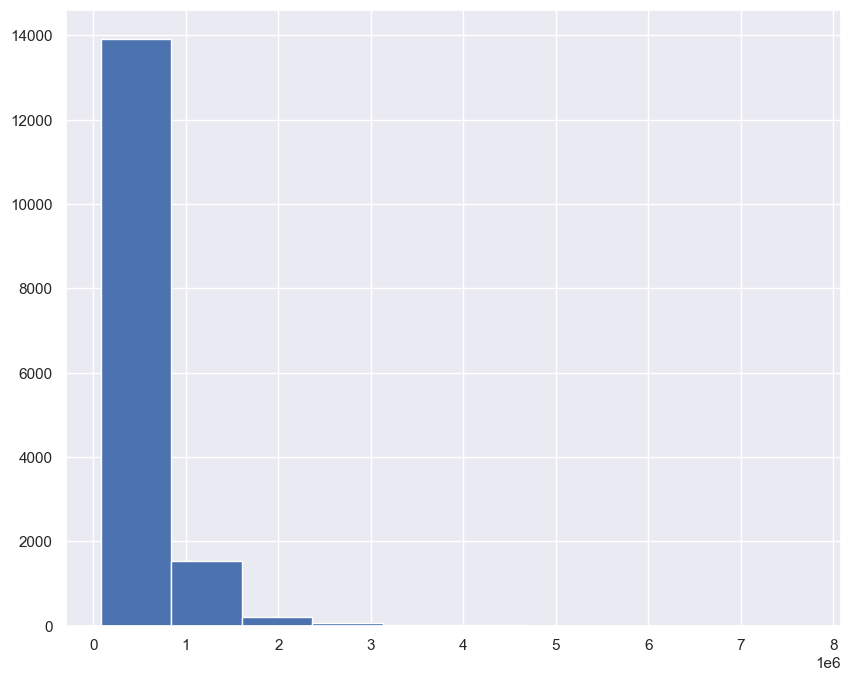

In [4]:
y = data.price
y.hist()

As price is heavily skewed, I will remove outliers.

<AxesSubplot:>

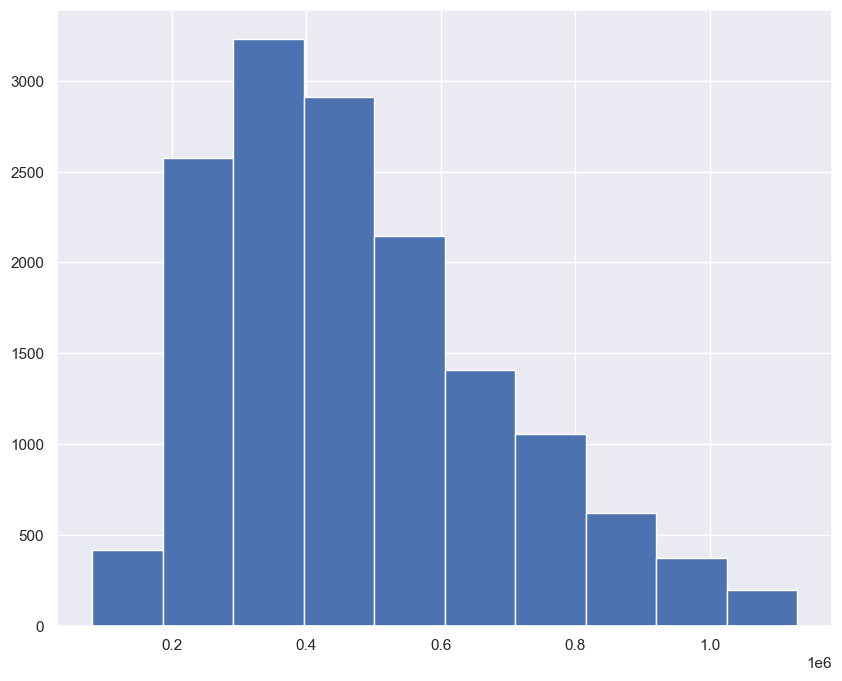

In [5]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))] # remove values that are > or < 1.5*IQR
    return df_final

y = remove_outlier_IQR(y)
y.hist()

Thats better.

In [6]:
corrs = data.loc[y.index].corrwith(y)
strong_corrs = corrs[abs(corrs) > 0.3] # filter weak correlations out
strong_corrs

price            1.000000
bathrooms        0.453918
sqft_living      0.624003
grade            0.633239
sqft_above       0.534376
lat              0.435178
sqft_living15    0.561940
dtype: float64

### IDENTIFYING INTERACTIONS

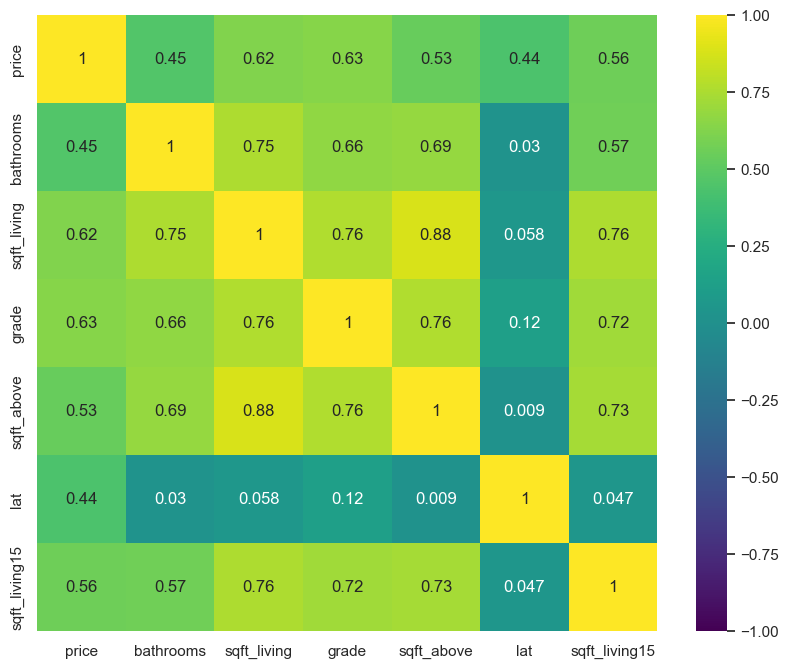

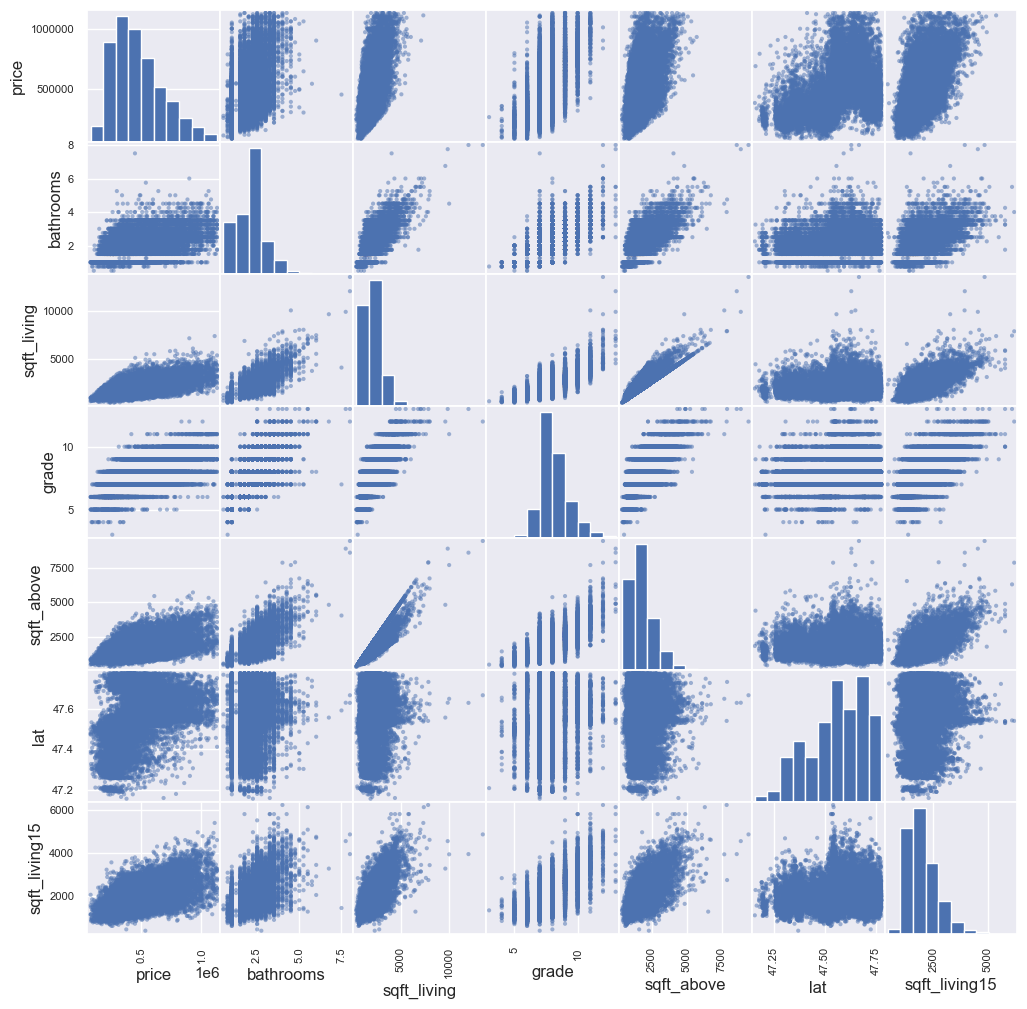

In [7]:
X = data[strong_corrs.index].drop("price", axis=1) # get the data associated with those columns and remove dependant variable

test_df = pd.concat([y, X], axis=1)
heatmap = sns.heatmap(test_df.corr(), vmin=-1, vmax=1, annot=True, cmap="viridis")

pd.plotting.scatter_matrix(test_df, figsize=(12, 12))
plt.show()

There appears to be a strong relationship between `sqft_above` and `sqft_living`.  This makes sens of course, as they include eachother in their calculations.  To avoid issues of colinearity, it makes sense to only include `sqft_living` then, as it has the strongest correlation with price.  It also seems that all of the predictors have a similarly skewed distribution as the price except for grade.  Grade is defined by The [King County Assessor website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g) as corresponding to the quality of contruction and materials and thus the cost of construction.

In [8]:
X.drop(columns=["sqft_above"], inplace=True)

In [9]:
categoricals = ["waterfront", "view"]
dummies = pd.get_dummies(data[categoricals], columns=categoricals ,prefix=categoricals, prefix_sep="_" , dtype=np.int64) # create dummy variables to include categorical variables
dummies.drop(columns=["waterfront_0", "view_NONE"], inplace=True) # drop the no waterfront and NONE views to compare those with to those without

X = pd.concat([X, dummies], axis=1).loc[y.index] # ensure that the target and predictors are aligned with loc[]

In [10]:
# Making a simple function to display relevant model metrics and test for assumptions of linear regression.
def evaluate_results(res, target:str="target") -> None:

    # Tests for linearity
    fig_pr, ax_pr = plt.subplots(figsize=(10, 10))
    sm.graphics.plot_partregress_grid(res, fig=fig_pr)
    rainbow = sm.stats.diagnostic.linear_rainbow(res) # linear rainbow test to confirm relationship is linear

    # Tests for heteroskedasticity
    fig, ax = plt.subplots()
    ax.scatter(y, res.resid, alpha = 0.3)
    ax.set_xlabel(target)
    ax.set_ylabel("residuals")
    ax.set_title("Heteroscedastic Residual Plot")
    GoldQuand = sm.stats.diagnostic.het_goldfeldquandt(res.resid, res.model.exog, alternative="two-sided")

    # Test for normal distribution of residuals
    sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)

    plt.show()

    print(res.summary())
    print(f"with a Rainbow Test pvalue of {round(rainbow[1], 3)}, we {'can' if rainbow[1] > 0.05 else 'cannot'} assume the relationship is linear")
    print(f"with a Goldfeld-Quandt Test pvalue of {GoldQuand[1]}, we {'can' if GoldQuand[1] > 0.05 else 'cannot'} assume homoscedasticity")

### BASELINE MODEL

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


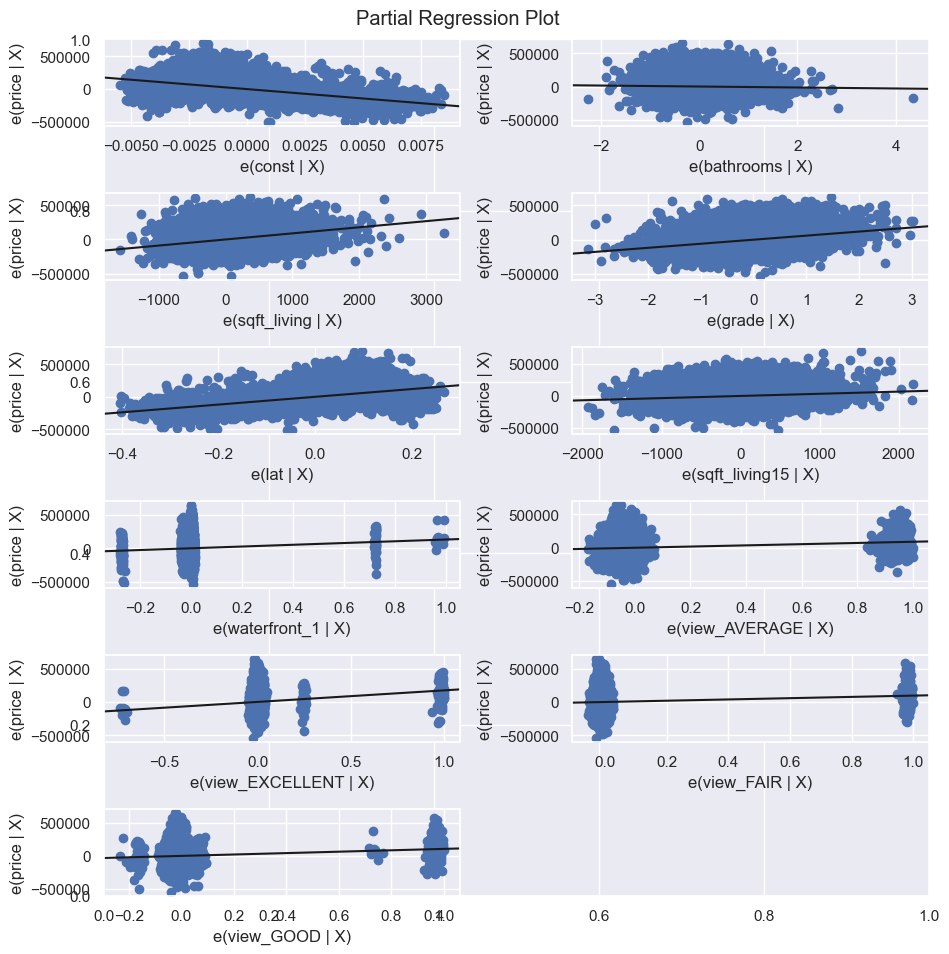

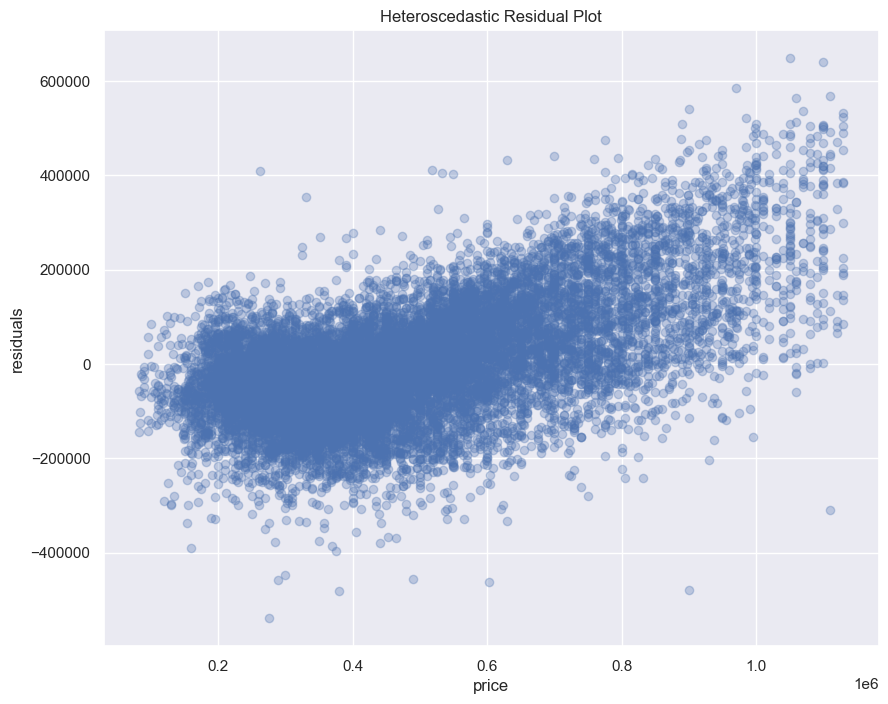

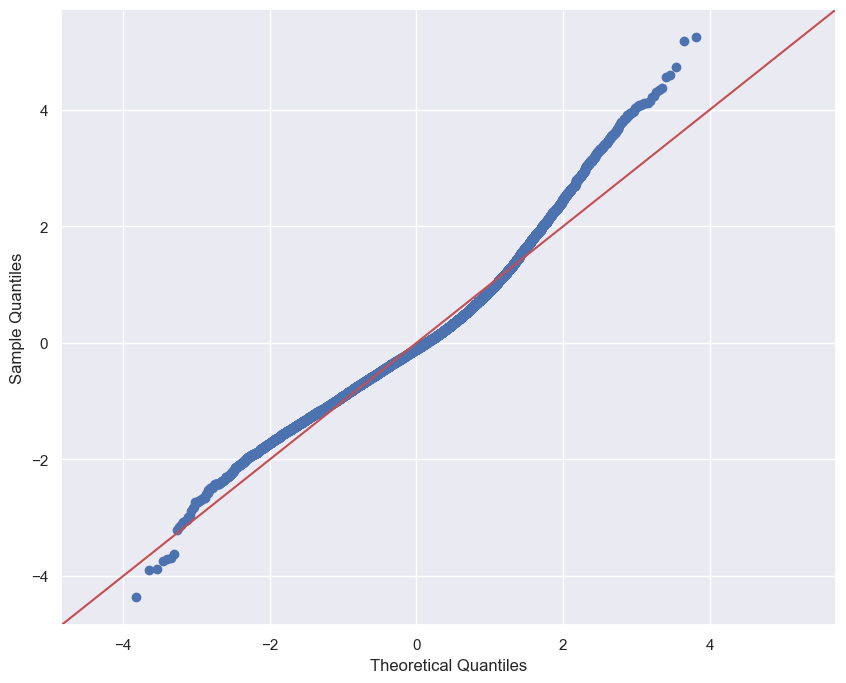

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2750.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:15:07   Log-Likelihood:            -1.9625e+05
No. Observations:               14931   AIC:                         3.925e+05
Df Residuals:                   14920   BIC:                         3.926e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.866e+07   3.43e+05    -83.

In [11]:
results = sm.OLS(y, sm.add_constant(X)).fit()
evaluate_results(results, "price")

#### Interpretation
The baseline model performed decently well, statistically signifficantly explaining about 65% of the variance in sale price.

All of the predictors were statistically significant:    
For each additional bathroom, there is a -7263.03 change in price  
For each additional sqft_living, there is a +89.07 change in price  
For each additional sqft_living15, there is a +33.78 change in price  
For each additional lat, there is a +598492.93 change in price  
For each additional grade, there is a +59058.73 change in price   
Houses on a waterfront have a 131,255.15 higher price tag compared to those not on a waterfront  
Houses with a "fair" view have a 95,636.39 higher price tag than those with "no view"  
Houses with a "average" view have a 90,037.47 higher price tag than those with "no view"  
Houses with a "good" view have a 105,346.57 higher price tag than those with "no view"  
Houses with a "excellent" view have a 173,596.66 higher price tag than those with "no view"  

It is odd that an increase in bathrooms supposedly decreases the price, so I will investigate that.

The assumptions of Linearity, Indepencance, Normality, Homoscedasticity (equal variances of the residuals/errors) hold in this model.  The Heterscedasticity plot and qq-plot look slightly irregular however, an as our target variable `price` had a slightly irregular distribution, I will log transform it to see if this improves the model.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


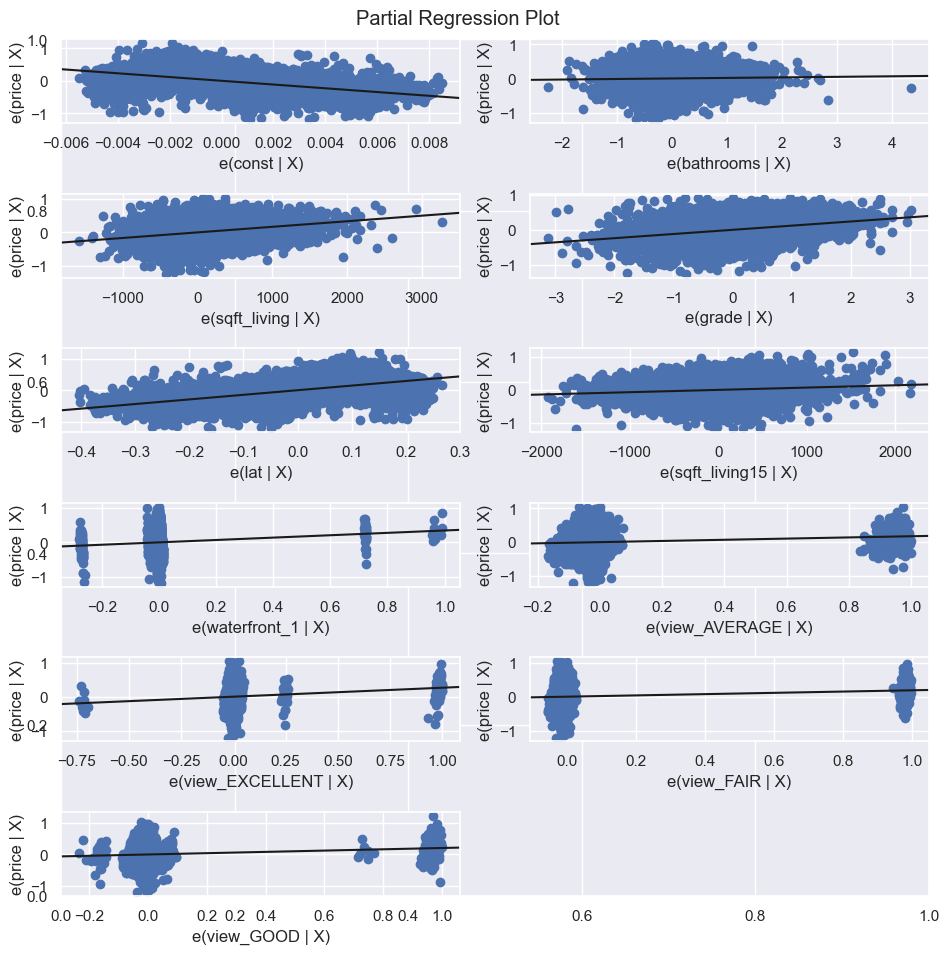

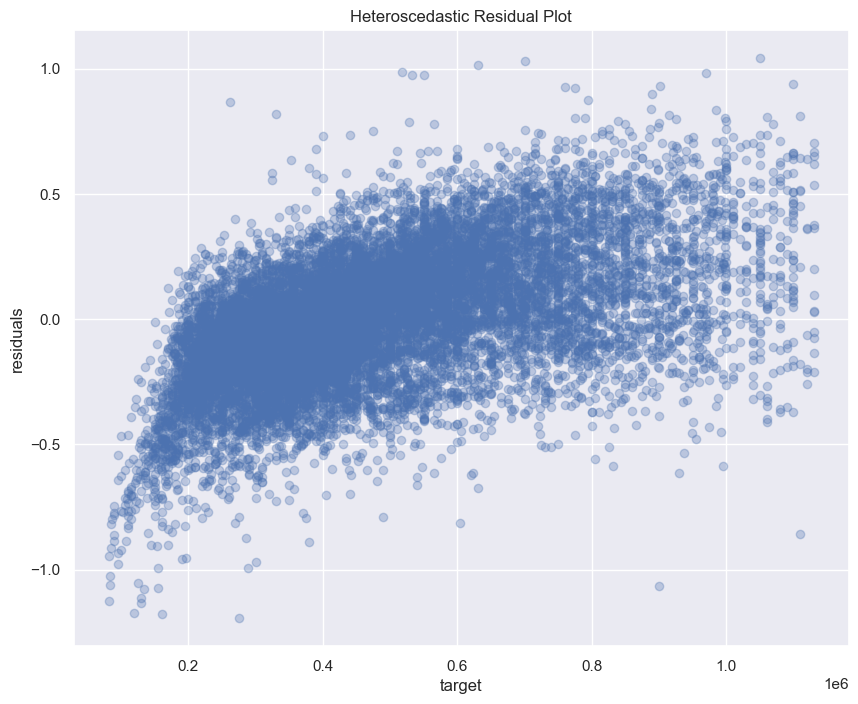

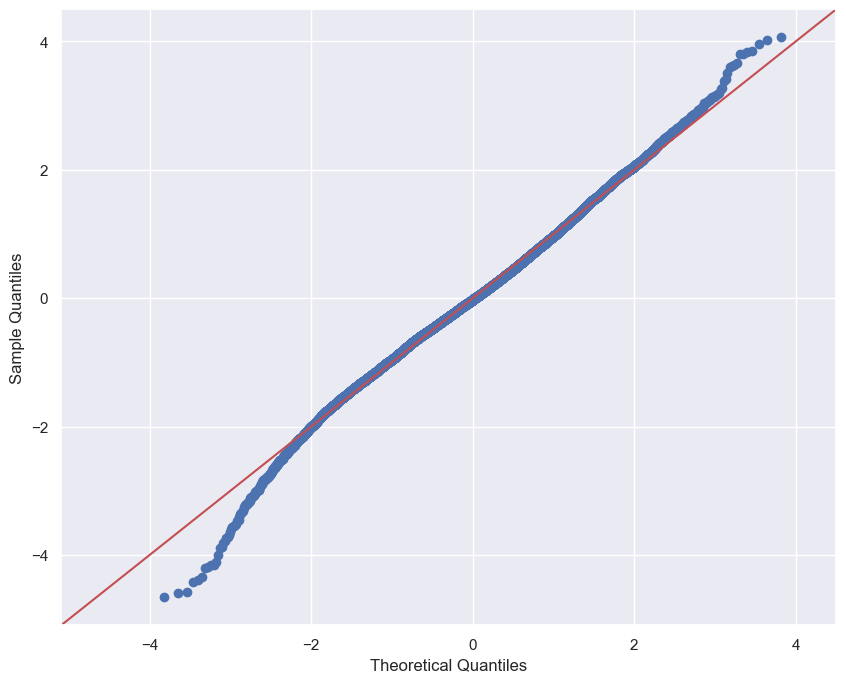

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2999.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:15:09   Log-Likelihood:                -863.55
No. Observations:               14931   AIC:                             1749.
Df Residuals:                   14920   BIC:                             1833.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -57.6450      0.712    -80.

In [12]:
# Model 2
y_log = np.log(y)
results_2 = sm.OLS(y_log, sm.add_constant(X)).fit()
evaluate_results(results_2)

#### Interpretation

The model remains significant with an increase in R2 from 0.648 to 0.668 (+0.02).  We can also see the qq-plot looks even more like a normal distribution, and our rainbow pvalue increased.  The Heterscedasticity plot looks slightly more Homoscedastic, but the Goldfeld-Quandt Test says otherwise.  The log transformation has also made the bathrooms coefficient positive. I do not want to log transform the predictors, so I will look at adding another predictor from the original data.

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

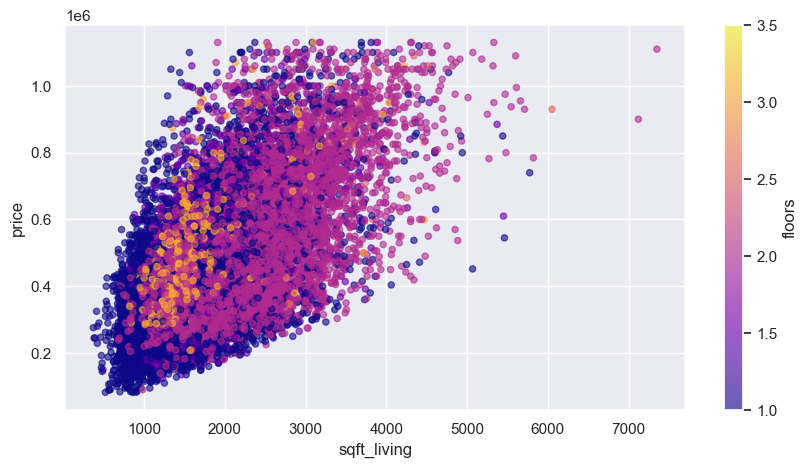

In [13]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10,5))
new_data = data.loc[y.index]
new_data.plot.scatter(x="sqft_living", y="price", c="floors", cmap="plasma", alpha=0.6, ax=ax) # check for interactions between sqft_living and other variables at c

Looking for interaction terms, I stumbled upon this interaction between `sqft_living` and `floors`, where it seems that there are ~3 separate populations within floors.  I will add `floors` to the independant variables as dummies as it is a categorical variable.

In [14]:
floor_dums = pd.get_dummies(data.loc[y.index].floors, prefix="floors", drop_first=True, dtype=np.int64)  # create dummies for floor variable
X2 = pd.concat([X.copy(), floor_dums], axis=1)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


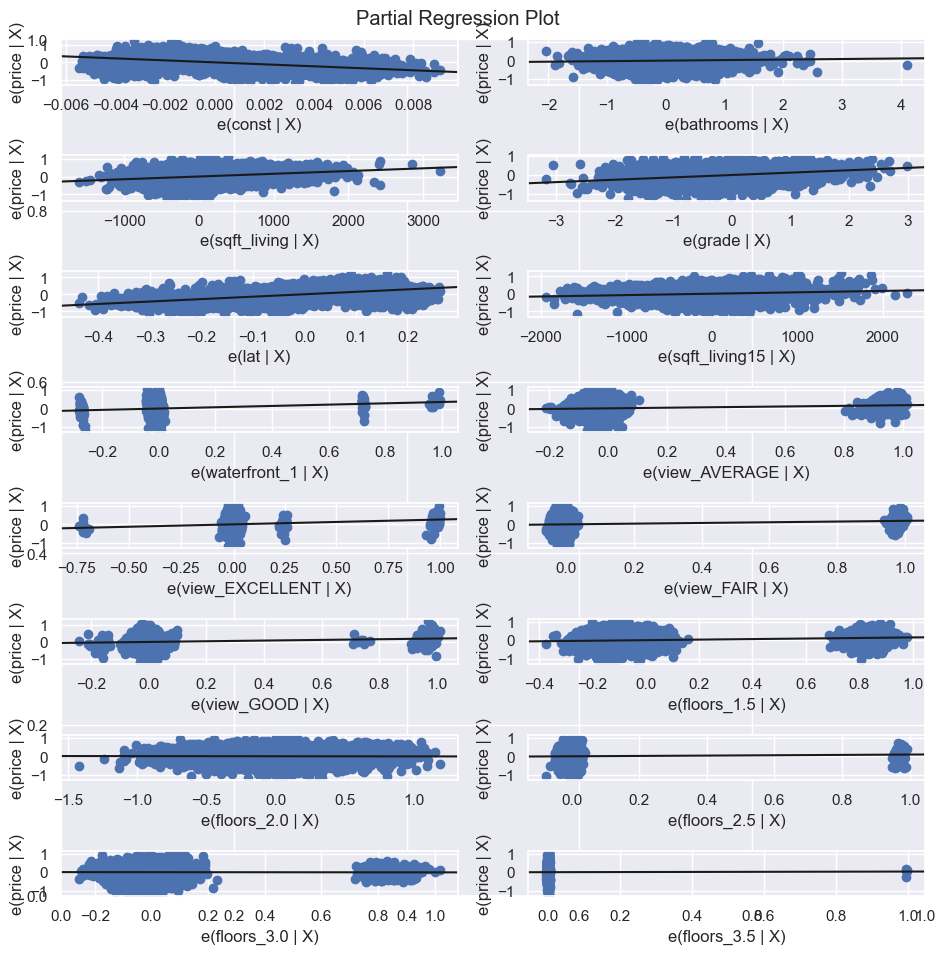

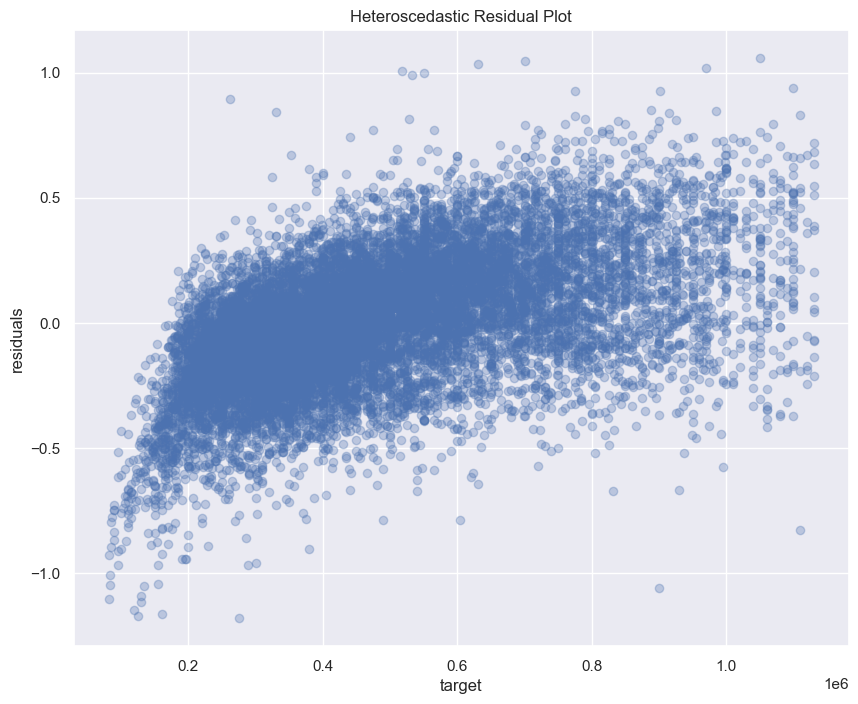

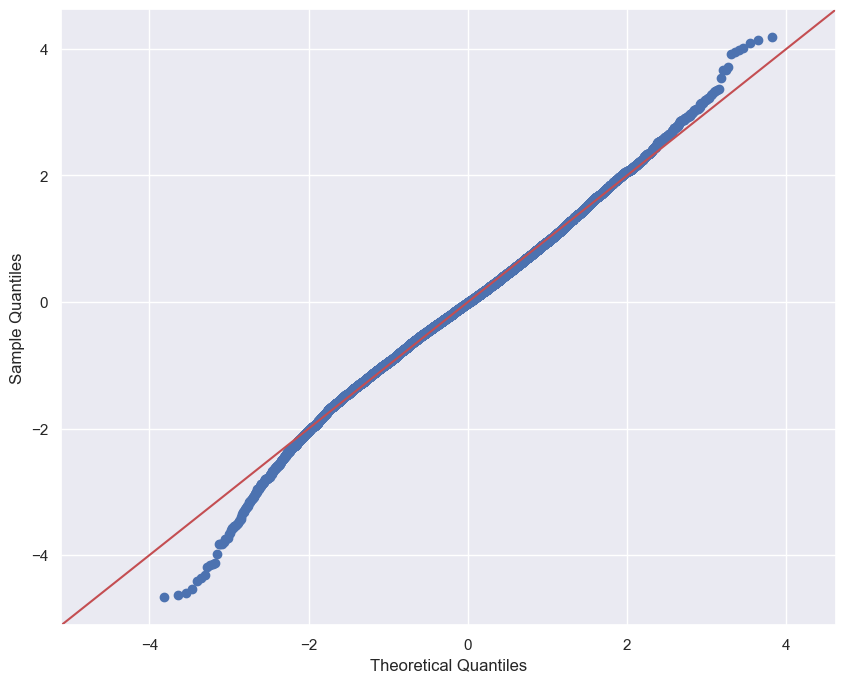

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     2081.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:15:13   Log-Likelihood:                -660.19
No. Observations:               14931   AIC:                             1352.
Df Residuals:                   14915   BIC:                             1474.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -56.5072      0.711    -79.

In [15]:
# Model 3
results_3 = sm.OLS(y_log, sm.add_constant(X2)).fit()
evaluate_results(results_3)

#### Interpretation

This seems to have slightly improved the model.  The adj. R2 increased modestly from 0.668 to 0.677 (0.009), and reduced our Heteroscedasticity.  `floors_1.5` and `floors_2.5` seem to be statistically signifficant, while the others are not.

Now I will see what happens when I create the interaction terms between `sqft_living` and `floors`.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


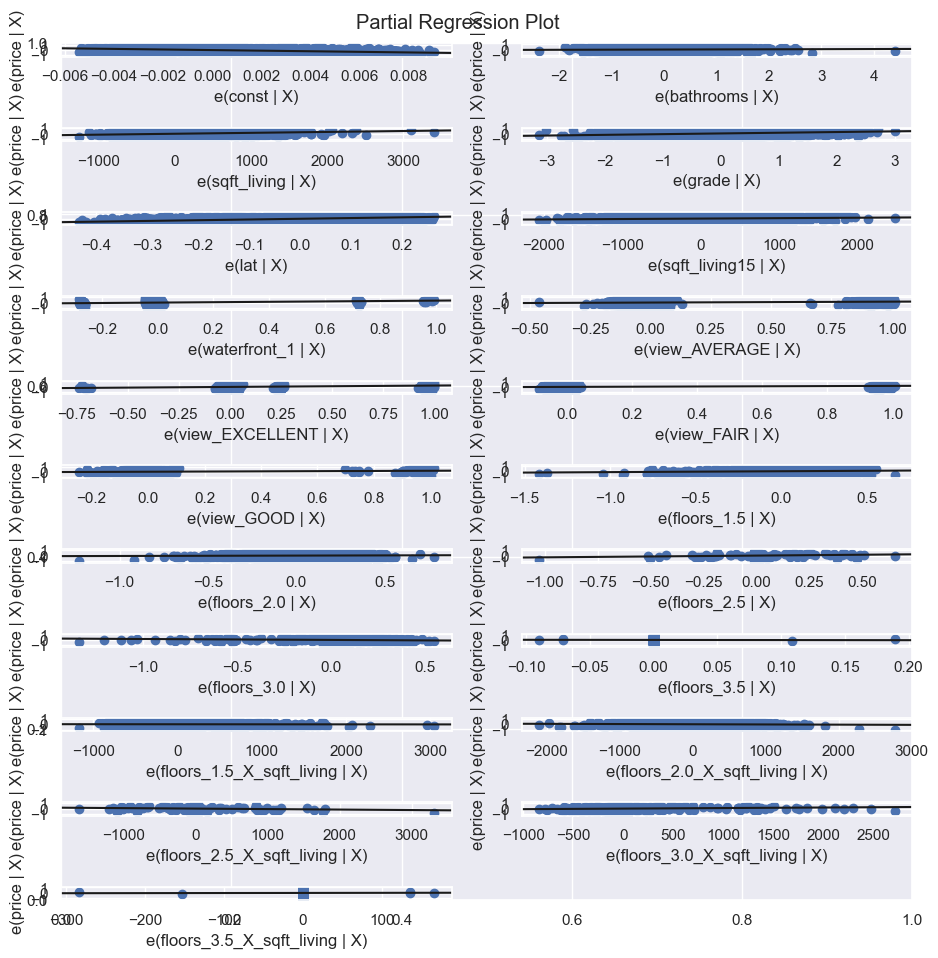

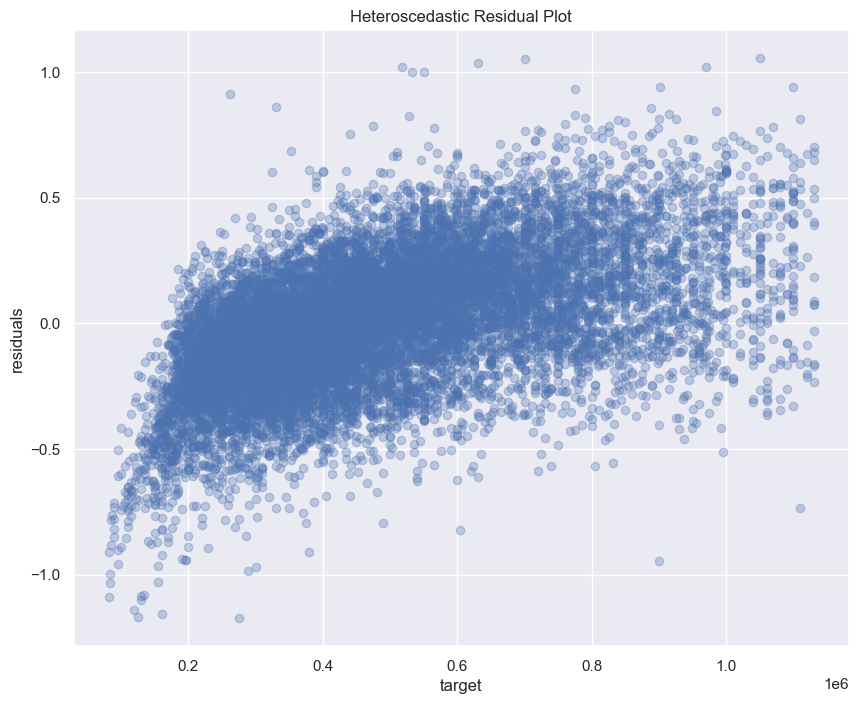

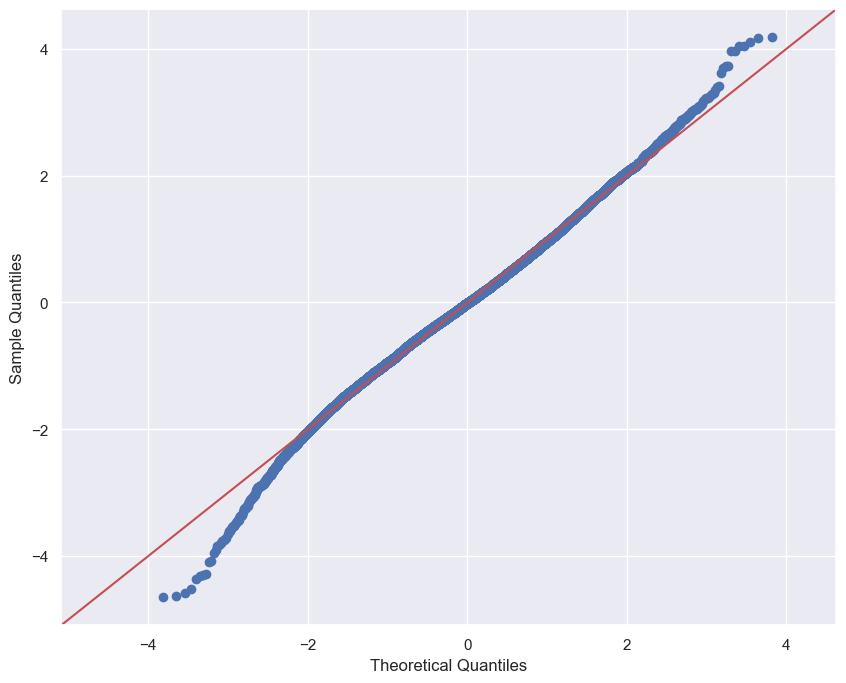

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     1570.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:15:16   Log-Likelihood:                -627.65
No. Observations:               14931   AIC:                             1297.
Df Residuals:                   14910   BIC:                             1457.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [16]:
# Model 4
interactions = floor_dums.multiply(X2.sqft_living, axis=0) # create a df of interaction terms
interactions.columns += "_X_sqft_living" # rename columns to reflect the modification

X3 = pd.concat([X2.copy(), interactions], axis=1) # add to old independant vars

results_4 = sm.OLS(y_log, sm.add_constant(X3)).fit()
evaluate_results(results_4)


#### Interpretation

This did not seem to improve the model, as our adj R2 only increased by 0.001, our heteroscedasticity increased, and our model has become more complex to interpret.  Finally, I will try applying the natural log to `sqft_living` and `sqft_living15` as they seemed to have non-normal distributions and may have a non-linear relationship with `price`.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


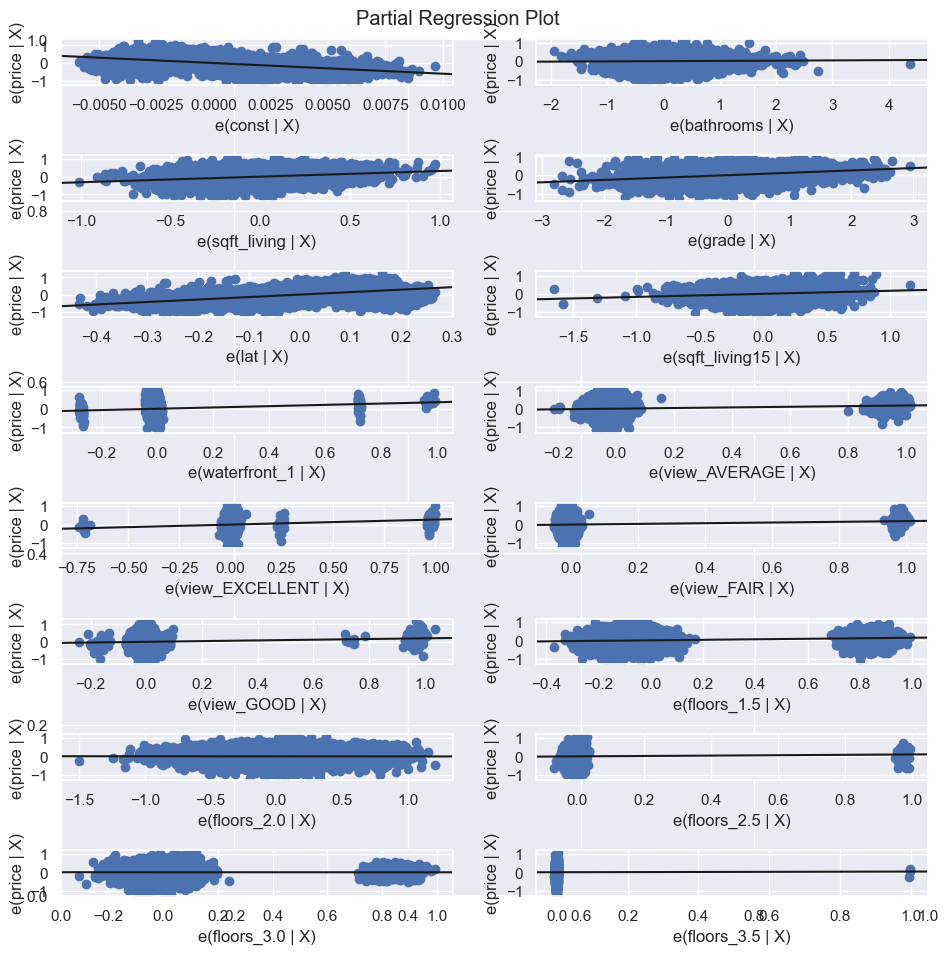

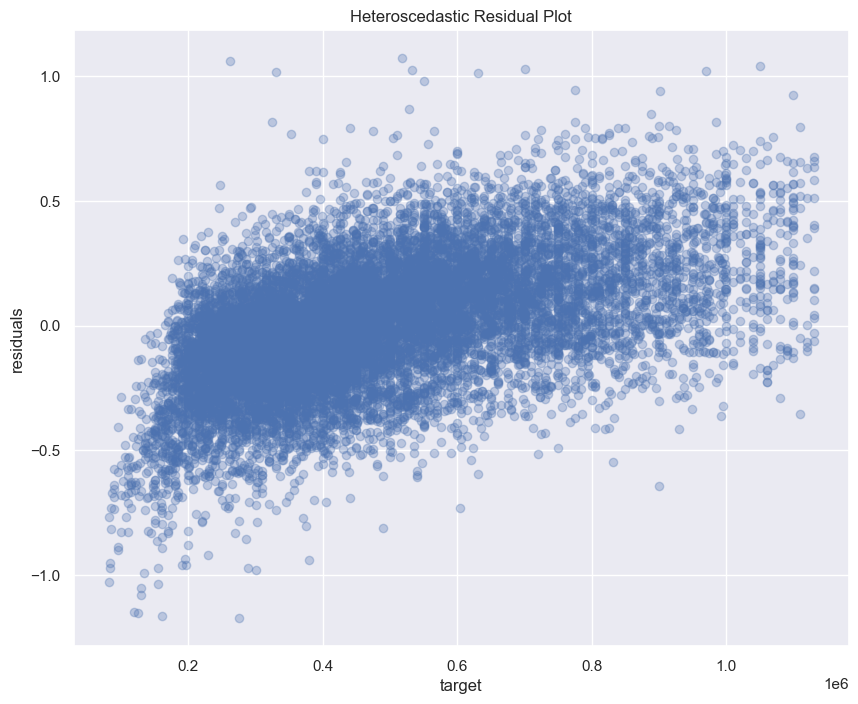

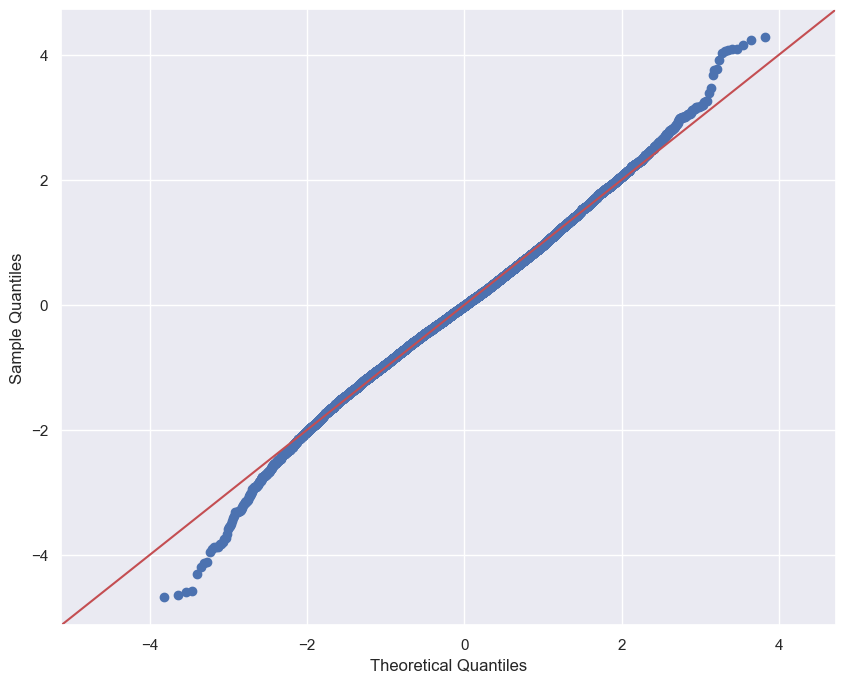

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     2131.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:15:19   Log-Likelihood:                -539.43
No. Observations:               14931   AIC:                             1111.
Df Residuals:                   14915   BIC:                             1233.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -60.0749      0.710    -84.

In [17]:
# Model 5
X4 = X2.copy()
X4.sqft_living = np.log(X4.sqft_living + 1e-5)
X4.sqft_living15 = np.log(X4.sqft_living15 + 1e-5)
# Log transform the sqft predictors

results_5 = sm.OLS(y_log, sm.add_constant(X4)).fit()
evaluate_results(results_5)

## CONCLUSION

I don't see many ways to improve the model much further.  I will select this fifth model to best describe this data.  The analysis follows:

First, I will remodel the same data with the independent variables normalized in order to compare their effects on the model.

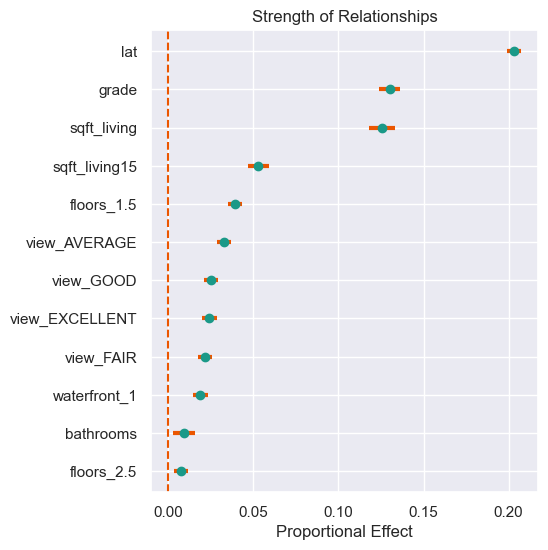

In [18]:
X_norm = X4.copy()
X_norm = (X_norm - X_norm.mean()) / X_norm.std() # Normalize the ind. variables by subtracting their means and dividing by their standard deviations
res_norm = sm.OLS(y_log, sm.add_constant(X_norm)).fit() # create a new model with the normalized X

to_include = res_norm.params[res_norm.pvalues < 0.05][1:].sort_values() # get the significant ind. variables coefficients and sort them 
fig, ax = plt.subplots(figsize=(5,6), dpi=100)
ax.scatter(to_include, range(len(to_include)), color="#1a9988", zorder=2)
ax.set_yticks(range(len(to_include)), to_include.index)
ax.set_xlabel("Proportional Effect")
ax.set_title("Strength of Relationships")

for idx, ci in enumerate(res_norm.conf_int().loc[to_include.index].iterrows()): # add hlines as error bars based upon the confidence intervals
    ax.hlines(idx, ci[1][0], ci[1][1], color="#eb5600", zorder=1, linewidth=3)

plt.axline((0,0), (0,1), color="#eb5600", linestyle="--")

#### Interpretation

The model statistically signifficantly explains ~68% of the variance in sale price.

From the normalized results, we can see that `sqft_living`, `grade`, and `lat` have the most effect on our model. Of those, sqft_living and grade are the most actionable for the purposes of a construction company.

For each additional bathroom, we see an associated increase of ~1.31% in price.  
**For each additional grade, we see an associated increase of ~13.35% in price.**  
For each additional degree of latitude in King County, we see an associated increase of ~321.30% in price.  
**For each increase of 1% sqft_living, we see an associated increase of ~0.32% in price.**  
For each increase of 1% sqft_living15, we see an associated increase of ~0.17% in price.  
Houses on a waterfront have a ~42% higher price compared to those not on a waterfront.  
Houses with a "fair" view have a ~20.5% higher price tag than those with "no view".  
Houses with a "average" view have a ~18.6% higher price tag than those with "no view".  
Houses with a "good" view have a ~22.4% higher price tag than those with "no view".  
Houses with a "excellent" view have a ~31.4% higher price tag than those with "no view".  
Houses with 1.5 floors have a ~14.8% higher price tag than those with one floor.  
Houses with 2.5 floors have a ~11.1% higher price tag than those with one floor.  

#### Recomendations
1. With respect to `sqft_living', It would be most profitable to maximize living squarefootage in any home constructed. This does not necessarily mean sacrificing non-living space, but is just a reccomendation to prioritize the size of areas such as living rooms and bedrooms over non-living areas.

2. With respect to `grade`, It would be most profitable to spend more on higher quality construction materials and have experienced contractors building the homes. This becomes an issue of diminishing marginal returns at a point that was not explained by the model. IE: at what point does it not become profitable to spend more on materials. This will need to be something decided by the individual construction company and their respective budgets.

#### Discussion and Caveats
Though we have a decent model, several of the predictors are not particularly useful.  Construction companies can rarely control whether their houses will be waterfront properties, have excellent views, or be further from the equator.  I considered removing latitude as it did not seem logical to me, but I left it in as I don't know enough about the geography of King County, Washington to say definitively that northernmost areas are considered more desireable.  For instance, maybe northernmost houses are closer to big cities, or are nearer to better school districts.  Grade, while a useful variable describing the quality of contruction and materials, is not speciffic enough to generate any real insight other than "you get what you pay for".